<a href="https://colab.research.google.com/github/IBM-EPBL/IBM-Project-5357-1658760171/blob/main/AircraftEngineFailureData_training_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
test_seq = np.load('/content/drive/MyDrive/colab data source/aircraft engine failure prediction/test_seq.npy', allow_pickle=True)
test_seq.shape

(93, 50, 12)

In [ ]:
train_seq = np.load('/content/drive/MyDrive/colab data source/aircraft engine failure prediction/train_seq.npy',allow_pickle=True)
train_seq.shape

(15631, 50, 12)

In [ ]:
label_array = np.load('/content/drive/MyDrive/colab data source/aircraft engine failure prediction/label_array.npy',allow_pickle=True)
label_array.shape

(15631, 1)

In [ ]:
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense , LSTM, Dropout
from keras.layers.core import Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import random
import tensorflow as tf
import os

In [ ]:
def seed_tensorflow(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed) 
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1' # `pip install tensorflow-determinism` first,使用与tf>2.1
    PYTHONHASHSEED=0
seed_tensorflow(42)

In [ ]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
def lstm_train(seq_array, label_array, sequence_length):
    # The first layer is an LSTM layer with 80 units followed by another LSTM layer with 40 units. 
    # Dropout is also applied after each LSTM layer to control overfitting. 
    # Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=80,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=40,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
    #
    print(model.summary())
    
    
    # fit the network # Commoly used 80 epoches but 50-60 are fine its an early cutoff 
    history = model.fit(seq_array, label_array, 
                        epochs=80, batch_size=200, 
                        validation_split=0.05, verbose=2,
                        callbacks = [ModelCheckpoint('best_model_val_r2_keras_' + '{val_r2_keras:.4f}' + '.h5', 
                                                    monitor='val_r2_keras', 
                                                    save_best_only = True, 
                                                    mode = 'max', 
                                                    verbose=0)])
    
    # list all data in history
    #print(history.history.keys())
    
    return model, history

In [ ]:
sequence_length = 50
sequence_cols = ['sensor_11', 'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17',
       'sensor_2', 'sensor_20', 'sensor_21', 'sensor_3', 'sensor_4',
       'sensor_7', 'sensor_8']

In [ ]:
model, history = lstm_train(train_seq, label_array, sequence_length)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 80)            29760     
                                                                 
 dropout (Dropout)           (None, 50, 80)            0         
                                                                 
 lstm_1 (LSTM)               (None, 40)                19360     
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 49,161
Trainable params: 49,161
Non-traina

In [ ]:
model.save('/content/drive/MyDrive/colab data source/aircraft engine failure prediction/LSTM_model.h5')

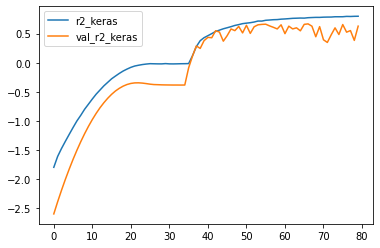

In [ ]:
hist_df = pd.DataFrame(data = np.array([history.history['r2_keras'],history.history['val_r2_keras']]).T, 
                       columns = ['r2_keras', 'val_r2_keras'])
hist_df.plot()

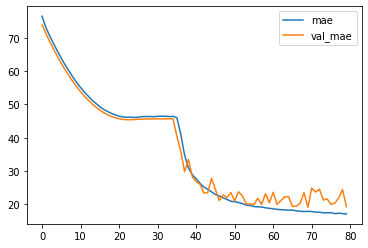

In [ ]:
hist_df = pd.DataFrame(data = np.array([history.history['mae'],history.history['val_mae']]).T, 
                       columns = ['mae', 'val_mae'])
hist_df.plot()

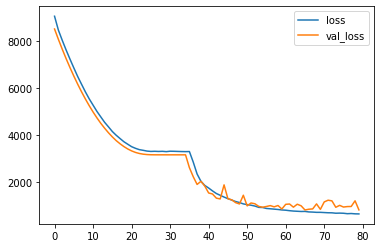

In [ ]:
hist_df = pd.DataFrame(data = np.array([history.history['loss'],history.history['val_loss']]).T, 
                       columns = ['loss', 'val_loss'])
hist_df.plot()

In [ ]:
test_seq = np.asarray(test_seq).astype(np.float32)

In [ ]:
y_pred_test = model.predict(test_seq,verbose=1, batch_size=200)

1/1 [==============================] - 1s 841ms/step
